# Step 8: Performance Interpretability
---
Goal of the notebook: Implement the permutation importance method and/or
the XPER method to identify the main drivers of the predictive performance of your model.
Are the drivers of the performance metric (Step 8) similar to the drivers of the individual
forecasts identified by SHAP (Step 7). 


Inputs of the notebook:

Output of the notebook:


Takeaways:

Questions, thoughts and remarks:

## Dependencies and path
Adjust the argument in `sys.path.append` to align with your specific requirements.

In [1]:
import pandas as pd 
import numpy as np
import os
import sys

%load_ext autoreload
%autoreload 2

os.chdir('C:/Users/dorab/OneDrive - Ecole Polytechnique/Documents/DSB - HECxX/Year 2/Algorithmic Fairness and Interpretability/afi_final_project')

## 1. Load the data

In [2]:
df = pd.read_excel("data/dataproject2024.xlsx")

In [3]:
X = df.drop(["Default (y)", "Pred_default (y_hat)", "ID", "PD", "Group"], axis=1)
y = df["Default (y)"]

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## 2. Best model (found in step 2 notebook)

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    random_state=42,
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=2,
    n_estimators=200,
    subsample=0.8,
)

model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42, subsample=0.8)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## 3. Evaluate performance
### 3.1 XPER

In [9]:
import XPER
from XPER.compute.Performance import ModelPerformance

# Define the evaluation metric(s) to be used
XPER = ModelPerformance(X_train.values, 
                        y_train.values, 
                        X_test.values, 
                        y_test.values, 
                        model)

# Evaluate the model performance using the specified metric(s)
PM_auc = XPER.evaluate(["AUC"])
PM_ba = XPER.evaluate(["Balanced_accuracy"])

# Print the performance metrics
print("Performance Metrics: ")
print("AUC: ", round(PM_auc, 3))
print("Balanced accuracy: ", round(PM_ba, 3))

Performance Metrics: 
AUC:  0.756
Balanced accuracy:  0.571


In [41]:
# Calculate XPER values for the model's performance
# XPER_values = XPER.calculate_XPER_values(["Balanced_accuracy"], kernel=True, N_coalition_sampled=10) # use this for if it takes too long to compute
XPER_values = XPER.calculate_XPER_values(["Balanced_accuracy"])

Performing Computation:   0%|          | 0/1 [00:00<?, ?it/s]

1022


In [11]:
from XPER.viz.Visualisation import visualizationClass as viz

labels = list(X.columns)

In [27]:
viz.bar_plot(XPER_values=XPER_values, X_test=X_test, labels=labels, p=10, percentage=True)

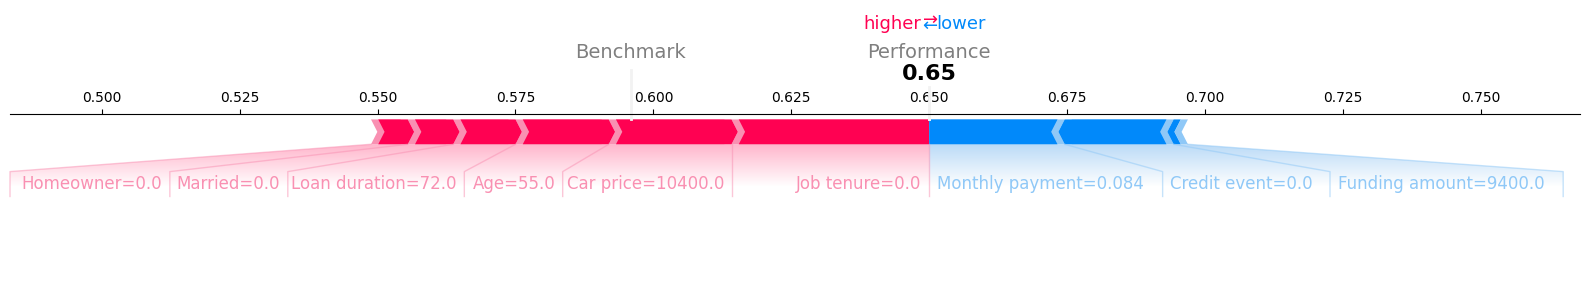

In [13]:
viz.force_plot(XPER_values=XPER_values, instance=1, X_test=X_test, variable_name=labels, figsize=(16,4))

DimensionError: Feature and SHAP matrices must have the same number of rows!

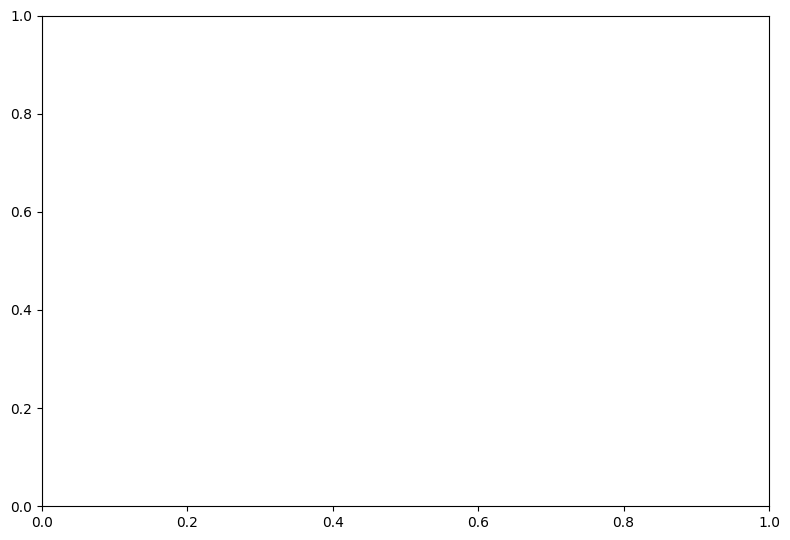

In [40]:
# Will only work once we 
# viz.beeswarn_plot(XPER_values=XPER_values, X_test=X_test, labels=labels)

### 3.2 Permutation Importance

In [8]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, X, y,
                           n_repeats=30,
                           random_state=0,
                           scoring='balanced_accuracy')

Only features with a significant contribution (where the mean importance minus two standard deviations is positive) are printed.

In [18]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]}: "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Funding amount: 0.046 +/- 0.005
Job tenure: 0.042 +/- 0.003
Monthly payment: 0.032 +/- 0.002
Age: 0.022 +/- 0.002
Homeowner: 0.019 +/- 0.002
Credit event: 0.014 +/- 0.002
Loan duration: 0.011 +/- 0.003


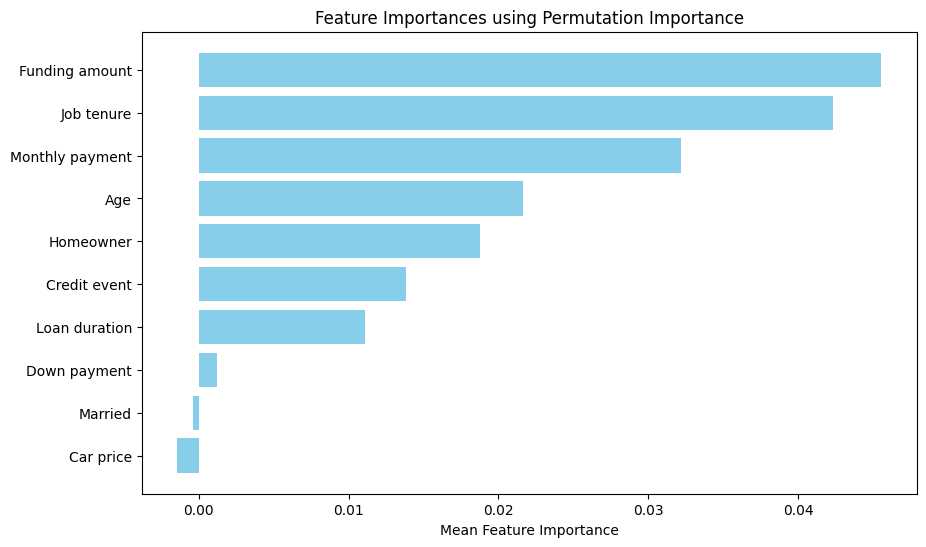

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assume X_val.columns contains the feature names, and r.importances_mean contains the importances
# Sorting features by importance
sorted_idx = np.argsort(r.importances_mean)

# Plotting horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], r.importances_mean[sorted_idx], color='skyblue')

# Adding labels and title
plt.xlabel('Mean Feature Importance')
plt.title('Feature Importances using Permutation Importance')
plt.show()
